<a href="https://colab.research.google.com/github/Abhi10699/google-colab-playground/blob/main/matrix_factorization_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Dummy Dataset


In [5]:
df = pd.DataFrame({
    "user_id": [1,2,3,3,1,4,5],
    "item_id": [1,1,2,1,4,3,4],
    "ratings": [0,4,3,0,1,1,3]
})
df

,user_id,item_id,ratings
0,1,1,0
1,2,1,4
2,3,2,3
3,3,1,0
4,1,4,1
5,4,3,1
6,5,4,3


In [8]:
unique_users = df.user_id.unique()
unique_items = df.item_id.unique()

num_users = len(unique_users)
num_items = len(unique_items)

In [9]:
num_users, num_items

(5, 4)

In [33]:
user2idx = {u: i for i,u in enumerate(unique_users)}
item2idx = {u: i for i,u in enumerate(unique_items)}


df['user_id_map'] = df['user_id'].apply(lambda x: user2idx[x])
df['item_id_map'] = df['item_id'].apply(lambda x: item2idx[x])

In [34]:
df

,user_id,item_id,ratings,user_id_map,item_id_map
0,1,1,0,0,0
1,2,1,4,1,0
2,3,2,3,2,1
3,3,1,0,2,0
4,1,4,1,0,2
5,4,3,1,3,3
6,5,4,3,4,2


## Embeddings

In [35]:
user_emb = nn.Embedding(num_users, 4)
item_emb = nn.Embedding(num_items, 4)

In [36]:
user_tensors = torch.LongTensor(df.user_id_map.values)
item_tensors = torch.LongTensor(df.item_id_map.values)

In [37]:
user_tensors, item_tensors

(tensor([0, 1, 2, 2, 0, 3, 4]), tensor([0, 0, 1, 0, 2, 3, 2]))

In [38]:
user_emb(user_tensors)

tensor([[-0.4317, -0.3891,  0.3683, -0.0888],
        [ 0.3073,  0.8244,  0.1086, -1.4489],
        [ 0.2021,  1.4057,  0.2008, -1.1855],
        [ 0.2021,  1.4057,  0.2008, -1.1855],
        [-0.4317, -0.3891,  0.3683, -0.0888],
        [ 0.0325, -0.7037, -1.7719,  0.3068],
        [-0.4595, -0.3044, -1.1782,  0.1212]], grad_fn=<EmbeddingBackward0>)

In [40]:
item_emb(item_tensors)

tensor([[-1.0490,  1.4158,  0.7193, -0.4408],
        [-1.0490,  1.4158,  0.7193, -0.4408],
        [ 0.1341,  1.4367, -0.4359, -1.0388],
        [-1.0490,  1.4158,  0.7193, -0.4408],
        [ 0.8084,  1.0966,  0.1201, -0.9222],
        [ 0.8723,  1.5919, -0.5320, -0.9433],
        [ 0.8084,  1.0966,  0.1201, -0.9222]], grad_fn=<EmbeddingBackward0>)

In [41]:
U = user_emb(user_tensors)
V = item_emb(item_tensors)

In [44]:
(U*V).sum(axis=1)

tensor([ 0.2061,  1.5617,  3.1906,  2.4452, -0.6495, -0.4387, -0.9585],
       grad_fn=<SumBackward1>)

## Model

In [48]:
class MatrixFactorizationModel(nn.Module):
  def __init__(self, num_users, num_items, latent_dim):
    super(MatrixFactorizationModel, self).__init__()

    self.user_emb = nn.Embedding(num_users, latent_dim)
    self.item_emb = nn.Embedding(num_items, latent_dim)

  def forward(self, users, items):
    U = self.user_emb(users)
    V = self.item_emb(items)

    return (U*V).sum(axis=1)

In [77]:
def train_model(model,users, items, ratings, lr=0.001,epochs=20):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  user_tensor = torch.LongTensor(users)
  item_tensor = torch.LongTensor(items)
  ratings_tensor = torch.FloatTensor(ratings)

  for epoch in range(epochs):
    model.train()

    # compute rating
    output = model(user_tensor, item_tensor)

    # compute loss
    loss = nn.functional.mse_loss(output, ratings_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"{epoch}/{epochs} -> Loss: {loss}")

In [78]:
model = MatrixFactorizationModel(num_users, num_items, 100)
train_model(model, df.user_id_map.values, df.item_id_map.values,df.ratings.values, lr=0.1,epochs=10)

0/10 -> Loss: 25.871448516845703
1/10 -> Loss: 85.14872741699219
2/10 -> Loss: 23.199127197265625
3/10 -> Loss: 23.959505081176758
4/10 -> Loss: 42.43574142456055
5/10 -> Loss: 31.59388542175293
6/10 -> Loss: 13.670991897583008
7/10 -> Loss: 7.762980937957764
8/10 -> Loss: 13.989066123962402
9/10 -> Loss: 19.02935791015625


In [56]:
train_model(model, lr=0.01,epochs=10)

0/10 -> Loss: 6.464131832122803
1/10 -> Loss: 2.5155906677246094
2/10 -> Loss: 0.755887508392334
3/10 -> Loss: 0.3669629991054535
4/10 -> Loss: 0.6146365404129028
5/10 -> Loss: 1.0495508909225464
6/10 -> Loss: 1.3766604661941528
7/10 -> Loss: 1.449202299118042
8/10 -> Loss: 1.2550595998764038
9/10 -> Loss: 0.8935852646827698


In [57]:
train_model(model, lr=0.001,epochs=10)

0/10 -> Loss: 0.514342188835144
1/10 -> Loss: 0.398395299911499
2/10 -> Loss: 0.3058469593524933
3/10 -> Loss: 0.23487511277198792
4/10 -> Loss: 0.18167413771152496
5/10 -> Loss: 0.1412452608346939
6/10 -> Loss: 0.10918445885181427
7/10 -> Loss: 0.08264918625354767
8/10 -> Loss: 0.0602722093462944
9/10 -> Loss: 0.04168657213449478


In [58]:
train_model(model, lr=0.001,epochs=10)

0/10 -> Loss: 0.027015598490834236
1/10 -> Loss: 0.007998750545084476
2/10 -> Loss: 0.0025230355095118284
3/10 -> Loss: 0.005499802064150572
4/10 -> Loss: 0.007924433797597885
5/10 -> Loss: 0.007501068525016308
6/10 -> Loss: 0.005561221856623888
7/10 -> Loss: 0.00402404647320509
8/10 -> Loss: 0.003451582510024309
9/10 -> Loss: 0.0030569355003535748


## Testing

In [67]:
model.eval()
model(torch.LongTensor([1]), torch.LongTensor([1]))

tensor([-8.3191], grad_fn=<SumBackward1>)

In [71]:
import numpy as np

def generate_ratings_data(num_users, num_items, num_ratings, min_rating=1, max_rating=5, random_seed=None):
    """
    Generates synthetic user-item ratings data for recommendation systems.

    Parameters:
    - num_users (int): Number of users.
    - num_items (int): Number of items.
    - num_ratings (int): Number of ratings to generate.
    - min_rating (int): Minimum rating value.
    - max_rating (int): Maximum rating value.
    - random_seed (int): Random seed for reproducibility.

    Returns:
    - user_item_ratings (numpy.ndarray): An array containing user, item, and rating data.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate random user and item IDs
    user_ids = np.random.randint(1, num_users + 1, size=num_ratings)
    item_ids = np.random.randint(1, num_items + 1, size=num_ratings)

    # Generate random ratings
    ratings = np.random.randint(min_rating, max_rating + 1, size=num_ratings)

    # Combine user IDs, item IDs, and ratings into a single array
    user_item_ratings = np.column_stack((user_ids, item_ids, ratings))

    columns = ["user_id", "item_id", "rating"]
    df = pd.DataFrame(data=user_item_ratings, columns=columns)
    return df

In [79]:
# Example usage:
num_users = 1000
num_items = 500
num_ratings = 10000
min_rating = 1
max_rating = 5
random_seed = 42

ratings_data = generate_ratings_data(num_users, num_items, num_ratings, min_rating, max_rating, random_seed)
ratings_data

,user_id,item_id,rating
0,103,442,4
1,436,279,5
2,861,251,5
3,271,310,3
4,107,208,3
...,...,...,...
9995,915,434,5
9996,210,493,1
9997,741,321,5
9998,862,108,2


In [80]:
unique_users = ratings_data.user_id.unique()
unique_items = ratings_data.item_id.unique()

user2idx = {u: i for i,u in enumerate(unique_users)}
item2idx = {u: i for i,u in enumerate(unique_items)}


ratings_data['user_id_map'] = ratings_data['user_id'].apply(lambda x: user2idx[x])
ratings_data['item_id_map'] = ratings_data['item_id'].apply(lambda x: item2idx[x])

In [81]:
ratings_data

,user_id,item_id,rating,user_id_map,item_id_map
0,103,442,4,0,0
1,436,279,5,1,1
2,861,251,5,2,2
3,271,310,3,3,3
4,107,208,3,4,4
...,...,...,...,...,...
9995,915,434,5,527,157
9996,210,493,1,764,291
9997,741,321,5,434,5
9998,862,108,2,914,31


In [93]:
model = MatrixFactorizationModel(num_users, num_items, 100)
users = torch.Longratings_data['user_id_map'].values
items = ratings_data['item_id_map'].values
ratings = ratings_data['rating'].values

In [94]:
train_model(model, users, items,ratings, lr=0.01,epochs=50)

0/50 -> Loss: 109.78150939941406
1/50 -> Loss: 100.67704010009766
2/50 -> Loss: 92.0745849609375
3/50 -> Loss: 83.9698715209961
4/50 -> Loss: 76.3565902709961
5/50 -> Loss: 69.22642517089844
6/50 -> Loss: 62.56914520263672
7/50 -> Loss: 56.37277603149414
8/50 -> Loss: 50.623741149902344
9/50 -> Loss: 45.30708312988281
10/50 -> Loss: 40.40660858154297
11/50 -> Loss: 35.90510940551758
12/50 -> Loss: 31.784549713134766
13/50 -> Loss: 28.02623748779297
14/50 -> Loss: 24.611038208007812
15/50 -> Loss: 21.519540786743164
16/50 -> Loss: 18.73222541809082
17/50 -> Loss: 16.229623794555664
18/50 -> Loss: 13.992454528808594
19/50 -> Loss: 12.001758575439453
20/50 -> Loss: 10.238996505737305
21/50 -> Loss: 8.686149597167969
22/50 -> Loss: 7.325793743133545
23/50 -> Loss: 6.141169548034668
24/50 -> Loss: 5.116224765777588
25/50 -> Loss: 4.235656261444092
26/50 -> Loss: 3.484936237335205
27/50 -> Loss: 2.850332498550415
28/50 -> Loss: 2.318916082382202
29/50 -> Loss: 1.878571629524231
30/50 -> Loss

In [95]:
train_model(model, users, items,ratings, lr=0.001,epochs=10)

0/10 -> Loss: 0.36602357029914856
1/10 -> Loss: 0.32525378465652466
2/10 -> Loss: 0.2875491678714752
3/10 -> Loss: 0.2528660297393799
4/10 -> Loss: 0.2211427539587021
5/10 -> Loss: 0.19230319559574127
6/10 -> Loss: 0.16625922918319702
7/10 -> Loss: 0.14291128516197205
8/10 -> Loss: 0.12214884907007217
9/10 -> Loss: 0.10385120660066605


In [96]:
user_tensor = torch.LongTensor(ratings_data['user_id_map'].values)
item_tensor = torch.LongTensor(ratings_data['item_id_map'].values)

In [100]:
model.eval()
model(user_tensor, item_tensor)

tensor([4.0065, 4.9780, 5.1848,  ..., 5.1246, 1.9774, 1.0931],
       grad_fn=<SumBackward1>)

# Clustering Users and Items

In [112]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [105]:
user_latent_features = model.user_emb.weight.detach().numpy()
item_latent_features = model.item_emb.weight.detach().numpy()

In [106]:
user_latent_features.shape, item_latent_features.shape

((1000, 100), (500, 100))

In [107]:
user_pca = PCA(n_components=2)
item_pca = PCA(n_components=2)

In [108]:
user_latent_components = user_pca.fit_transform(user_latent_features)
item_latent_components = item_pca.fit_transform(item_latent_features)

In [110]:
def train_clusters(data, max_clusters):
  inertia_history = []
  K_history = []

  for K in range(2, max_clusters):
    clustering_model = KMeans(K)
    clustering_model.fit(data)

    inertia = clustering_model.inertia_
    inertia_history.append(inertia)
    K_history.append(K)

  plt.plot(K_history, inertia_history)

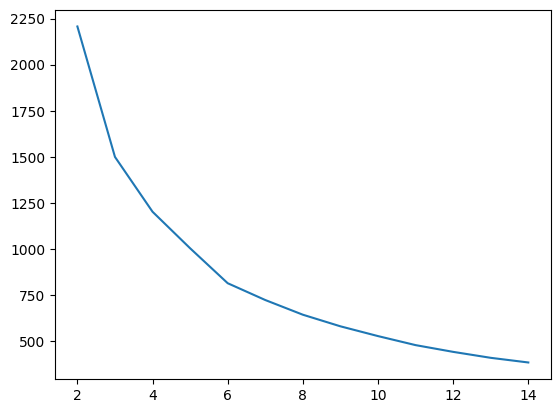

In [114]:
train_clusters(user_latent_components, 15)

Optimal Cluster Size: 6

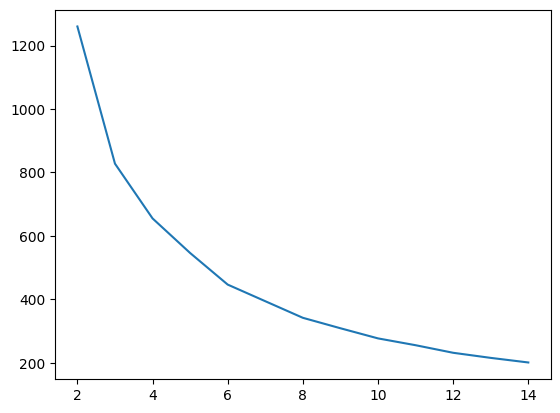

In [115]:
train_clusters(item_latent_components, 15)

Optimal Cluster Size: 6

In [120]:
user_cluster = KMeans(n_clusters=6).fit_predict(user_latent_components)
item_cluster = KMeans(n_clusters=6).fit_predict(item_latent_components)

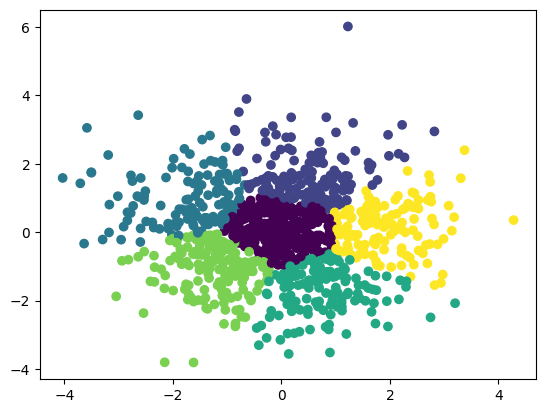

In [129]:
plt.scatter(user_latent_components[:,0], user_latent_components[:,1],c=user_cluster)
plt.show()

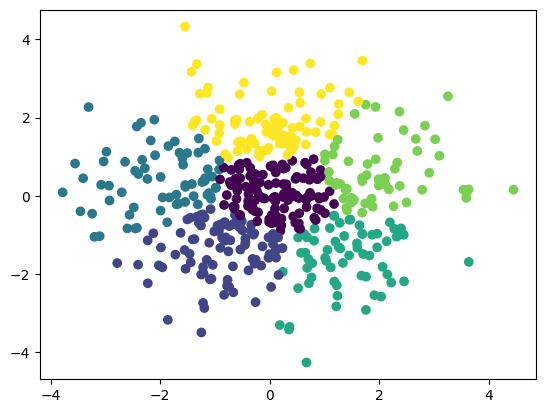

In [130]:
plt.scatter(item_latent_components[:,0], item_latent_components[:,1],c=item_cluster)
plt.show()